# Naive Bayes

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from d2l.tensorflow import config

import numpy as np
import matplotlib.pyplot as plt

import urllib3

urllib3.disable_warnings()
config.setup()

In [2]:
def transform(image, label):
    return image / 255, label

In [3]:
ds = tfds.load('mnist', shuffle_files=True)

In [4]:
mnist_train = ds['train'].shuffle(1024).batch(64).prefetch(
    tf.data.experimental.AUTOTUNE
)

In [5]:
for example in mnist_train.take(1):
    image_train, label_train = transform(example["image"], example["label"])

In [6]:
xcount = tf.Variable(tf.ones((10, 784)))
ycount = tf.Variable(tf.ones((10)))

In [7]:
for data, label in zip(image_train, label_train):
    y = int(label)
    ycount.assign(tf.tensor_scatter_nd_add(ycount, [[y]], [1]))
    res = tf.reshape(data, (784))
    xcount.assign(tf.tensor_scatter_nd_add(xcount, [[y]], [res]))
xcount = tf.transpose(xcount)

In [8]:
py = ycount / tf.math.reduce_sum(ycount)
px = xcount / tf.reshape(ycount, (1, 10))

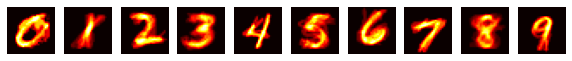

Class probabilities
[0.05405406 0.10810811 0.08108108 0.14864865 0.05405406 0.10810811
 0.12162162 0.06756756 0.1891892  0.06756756]


In [9]:
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))

for i in range(10):
    figarr[i].imshow(tf.reshape(xcount[:, i], (28, 28)), cmap='hot')
    figarr[i].axis(False)

plt.show()
print('Class probabilities', py.numpy(), sep='\n')

## Naive Normalization (without logsum)

In [10]:
mnist_test = ds['test'].shuffle(1024).batch(16).prefetch(
    tf.data.experimental.AUTOTUNE
)

for example in mnist_test.take(1):
    image_test, label_test = transform(example["image"], example["label"])

In [11]:
# get the first test item
data, label = tf.reshape(image_test[0], (784, 1)), label_test[0]

# compute the per pixel conditional probabilities
xprob = (px * data + (1 - px) * (1 - data))

# take the product
xprob = tf.math.reduce_prod(xprob, 0) * py
print('Unnormalized Probabilities', xprob.numpy(), sep='\n')

# take the product
xprob = xprob / tf.math.reduce_sum(xprob)
print('Normalized Probabilities', xprob.numpy(), sep='\n')

Unnormalized Probabilities
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Probabilities
[nan nan nan nan nan nan nan nan nan nan]


## Normalization (with logsum)

In [12]:
logpx = tf.math.log(px)
logpxneg = tf.math.log(1 - px)
logpy = tf.math.log(py)

def bayespost(data):
    # we need to incorporate the prior probability p(y) since p(x|y) is proportional to p(x|y) p(y)
    logpost = tf.Variable(logpy)
    
    xprob = logpx * data + logpxneg * (1 - data)
    filter_ = ~tf.math.is_finite(xprob)
    replace_ = tf.zeros_like(xprob)
    xprob = tf.where(filter_, replace_, xprob)
    
    logpost.assign_add(tf.math.reduce_sum(xprob, 0))
    
    # normalize to prevent overflow or underflow by subtracting the largest value
    logpost.assign_sub([tf.math.reduce_max(logpost)] * logpost.shape[0])
    post = tf.math.exp(logpost)
    post /= tf.math.reduce_sum(post)
    return post

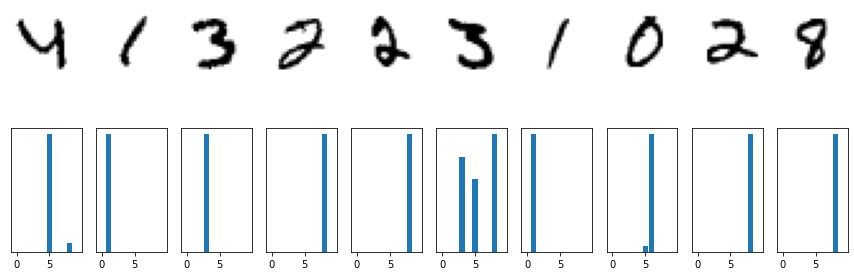

Accuracy: 40.0%


In [13]:
fig, figarr = plt.subplots(2, 10, figsize=(15, 5))

acc = []
for i, (data, label) in enumerate(zip(image_test[:10], label_test)):
    x = tf.reshape(data, (784, 1))
    y = int(label)
    post = bayespost(x)
    figarr[1, i].bar(range(10), post)
    figarr[1, i].axes.yaxis.set_visible(False)
    figarr[0, i].imshow(tf.reshape(x, (28, 28)), cmap='binary')
    figarr[0, i].axis(False)
    acc.append(tf.get_static_value(tf.math.argmax(post) == y))

plt.show()
print('Accuracy: {}%'.format((sum(acc) / len(acc)) * 100))